In [17]:
from os import path, listdir
from PIL import Image
import numpy as np

from tensorflow.keras.layers import GaussianNoise, Input, Reshape, Dropout, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow import clip_by_value
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [18]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [19]:
def get_data(directory: str) -> "tuple[np.ndarray, np.ndarray]":
    ima = listdir(path.join(directory, "PNEUMONIA"))
    nema = listdir(path.join(directory, "NORMAL"))
    size = len(ima) + len(nema)
    X = np.empty((size, 250, 350), dtype=np.uint8)
    y = np.empty((size), dtype=np.uint8)
    for i, file in enumerate(ima):
        X[i] = np.asarray(Image.open(path.join(directory, "PNEUMONIA", file)))
        y[i] = 1
    for i, file in enumerate(nema):
        X[len(ima) + i] = np.asarray(Image.open(path.join(directory, "NORMAL", file)))
        y[len(ima) + i] = 0
    return X , y

In [20]:
def make_model(input_shape, learning_rate):
    input_layer = Input(input_shape)
    rs = Rescaling(scale=1/255.0)(input_layer)
    gauss = GaussianNoise(1.5/255.0)(rs)
    clip_input = clip_by_value(gauss, 0, 1)
    reshape_input = Reshape((input_shape[0], input_shape[1], 1))(clip_input)

    c1 = Conv2D(16, (3,3), activation="relu")(reshape_input)
    mp1 = MaxPool2D((3,3))(c1)
    c2 = Conv2D(16, (4,4), activation="relu")(mp1)
    mp2 = MaxPool2D((4,4))(c2)
    c3 = Conv2D(32, (5,5), activation="relu")(mp2)
    mp3 = MaxPool2D((5,5))(c3)
    drop1 = Dropout(0.2)(mp3) 
    flat = Flatten()(drop1)
    
    d1 = Dense(256, activation="relu")(flat)
    d2 = Dense(128, activation="relu")(d1)
    
    drop2 = Dropout(0.3)(d2)
    output_layer = Dense(1, activation="sigmoid")(drop2)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy',Precision(), Recall()])
    return model

In [23]:
directory_train = "../chest_xray_norm/train"
x_train, y_train = get_data(directory_train)

directory_val = "../chest_xray_norm/val"
x_val, y_val = get_data(directory_val)

model = make_model(x_train[0].shape, 0.001)
model.summary()

history = model.fit(x_train, y_train, epochs=500, batch_size=0, verbose=1, shuffle=True, validation_data=(x_val,y_val))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 250, 350)]        0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 250, 350)          0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 250, 350)          0         
_________________________________________________________________
tf.clip_by_value_4 (TFOpLamb (None, 250, 350)          0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 250, 350, 1)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 248, 348, 16)      160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 82, 116, 16)       0   

Epoch 25/500
163/163 [==============================] - 13s 78ms/step - loss: 0.0238 - accuracy: 0.9920 - precision_1: 0.9945 - recall_1: 0.9948 - val_loss: 0.1188 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 26/500
163/163 [==============================] - 13s 78ms/step - loss: 0.0245 - accuracy: 0.9911 - precision_1: 0.9949 - recall_1: 0.9931 - val_loss: 0.2677 - val_accuracy: 0.9375 - val_precision_1: 0.8889 - val_recall_1: 1.0000
Epoch 27/500
163/163 [==============================] - 13s 78ms/step - loss: 0.0183 - accuracy: 0.9943 - precision_1: 0.9959 - recall_1: 0.9964 - val_loss: 0.9586 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 28/500
163/163 [==============================] - 13s 78ms/step - loss: 0.0144 - accuracy: 0.9949 - precision_1: 0.9960 - recall_1: 0.9972 - val_loss: 0.6639 - val_accuracy: 0.7500 - val_precision_1: 0.6667 - val_recall_1: 1.0000
Epoch 29/500
163/163 [==============================] - 

Epoch 60/500
163/163 [==============================] - 13s 80ms/step - loss: 0.0057 - accuracy: 0.9988 - precision_1: 0.9990 - recall_1: 0.9994 - val_loss: 0.4317 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 61/500
163/163 [==============================] - 13s 79ms/step - loss: 9.6767e-04 - accuracy: 0.9999 - precision_1: 0.9999 - recall_1: 1.0000 - val_loss: 2.1605 - val_accuracy: 0.7500 - val_precision_1: 0.6667 - val_recall_1: 1.0000
Epoch 62/500
163/163 [==============================] - 13s 77ms/step - loss: 0.0094 - accuracy: 0.9974 - precision_1: 0.9974 - recall_1: 0.9991 - val_loss: 0.4112 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 63/500
163/163 [==============================] - 13s 79ms/step - loss: 0.0117 - accuracy: 0.9956 - precision_1: 0.9964 - recall_1: 0.9978 - val_loss: 0.7159 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 64/500
163/163 [==============================

Epoch 95/500
163/163 [==============================] - 13s 80ms/step - loss: 0.0062 - accuracy: 0.9982 - precision_1: 0.9989 - recall_1: 0.9987 - val_loss: 0.0611 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 96/500
163/163 [==============================] - 13s 80ms/step - loss: 0.0125 - accuracy: 0.9948 - precision_1: 0.9971 - recall_1: 0.9959 - val_loss: 0.9848 - val_accuracy: 0.7500 - val_precision_1: 0.6667 - val_recall_1: 1.0000
Epoch 97/500
163/163 [==============================] - 14s 83ms/step - loss: 0.0013 - accuracy: 0.9997 - precision_1: 0.9999 - recall_1: 0.9997 - val_loss: 1.7821 - val_accuracy: 0.7500 - val_precision_1: 0.6667 - val_recall_1: 1.0000
Epoch 98/500
163/163 [==============================] - 13s 79ms/step - loss: 0.0044 - accuracy: 0.9981 - precision_1: 0.9986 - recall_1: 0.9988 - val_loss: 0.4565 - val_accuracy: 0.9375 - val_precision_1: 0.8889 - val_recall_1: 1.0000
Epoch 99/500
163/163 [==============================] - 

163/163 [==============================] - 13s 78ms/step - loss: 0.0038 - accuracy: 0.9987 - precision_1: 0.9992 - recall_1: 0.9991 - val_loss: 1.1766 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 164/500
163/163 [==============================] - 13s 78ms/step - loss: 0.0108 - accuracy: 0.9975 - precision_1: 0.9986 - recall_1: 0.9981 - val_loss: 1.1942 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 165/500
163/163 [==============================] - 13s 79ms/step - loss: 0.0044 - accuracy: 0.9981 - precision_1: 0.9990 - recall_1: 0.9984 - val_loss: 0.2428 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 166/500
163/163 [==============================] - 13s 79ms/step - loss: 0.0020 - accuracy: 0.9991 - precision_1: 1.0000 - recall_1: 0.9988 - val_loss: 0.6765 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 167/500
163/163 [==============================] - 13s 79ms/

163/163 [==============================] - 13s 78ms/step - loss: 0.0061 - accuracy: 0.9989 - precision_1: 0.9992 - recall_1: 0.9994 - val_loss: 0.7859 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 232/500
163/163 [==============================] - 13s 78ms/step - loss: 1.1867e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 1.4360 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 233/500
163/163 [==============================] - 13s 78ms/step - loss: 0.0011 - accuracy: 0.9999 - precision_1: 1.0000 - recall_1: 0.9999 - val_loss: 1.3417 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 234/500
163/163 [==============================] - 13s 78ms/step - loss: 0.0079 - accuracy: 0.9975 - precision_1: 0.9986 - recall_1: 0.9980 - val_loss: 1.3593 - val_accuracy: 0.7500 - val_precision_1: 0.6667 - val_recall_1: 1.0000
Epoch 235/500
163/163 [==============================] - 13s 7

163/163 [==============================] - 13s 78ms/step - loss: 3.0768e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 2.2641 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 300/500
163/163 [==============================] - 13s 78ms/step - loss: 3.0468e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 2.8339 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 301/500
163/163 [==============================] - 13s 78ms/step - loss: 3.9891e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 2.6036 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 302/500
163/163 [==============================] - 13s 78ms/step - loss: 8.0952e-04 - accuracy: 0.9997 - precision_1: 0.9998 - recall_1: 0.9998 - val_loss: 1.2000 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 303/500
163/163 [===========================

163/163 [==============================] - 13s 78ms/step - loss: 7.1666e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 1.6677 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 368/500
163/163 [==============================] - 13s 82ms/step - loss: 9.6894e-05 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 1.9253 - val_accuracy: 0.7500 - val_precision_1: 0.6667 - val_recall_1: 1.0000
Epoch 369/500
163/163 [==============================] - 13s 82ms/step - loss: 0.0063 - accuracy: 0.9986 - precision_1: 0.9986 - recall_1: 0.9996 - val_loss: 1.3788 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 370/500
163/163 [==============================] - 13s 80ms/step - loss: 0.0015 - accuracy: 0.9990 - precision_1: 0.9996 - recall_1: 0.9991 - val_loss: 0.7480 - val_accuracy: 0.6875 - val_precision_1: 0.6154 - val_recall_1: 1.0000
Epoch 371/500
163/163 [==============================] - 1

163/163 [==============================] - 12s 74ms/step - loss: 7.1660e-04 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 2.2682 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 436/500
163/163 [==============================] - 12s 74ms/step - loss: 2.6885e-04 - accuracy: 0.9999 - precision_1: 1.0000 - recall_1: 0.9999 - val_loss: 2.8471 - val_accuracy: 0.7500 - val_precision_1: 0.6667 - val_recall_1: 1.0000
Epoch 437/500
163/163 [==============================] - 12s 74ms/step - loss: 9.8474e-04 - accuracy: 0.9994 - precision_1: 0.9993 - recall_1: 1.0000 - val_loss: 2.9843 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000
Epoch 438/500
163/163 [==============================] - 12s 74ms/step - loss: 3.4452e-04 - accuracy: 0.9998 - precision_1: 1.0000 - recall_1: 0.9997 - val_loss: 2.6675 - val_accuracy: 0.8750 - val_precision_1: 0.8000 - val_recall_1: 1.0000
Epoch 439/500
163/163 [===========================

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

In [26]:
import matplotlib.pyplot as plt

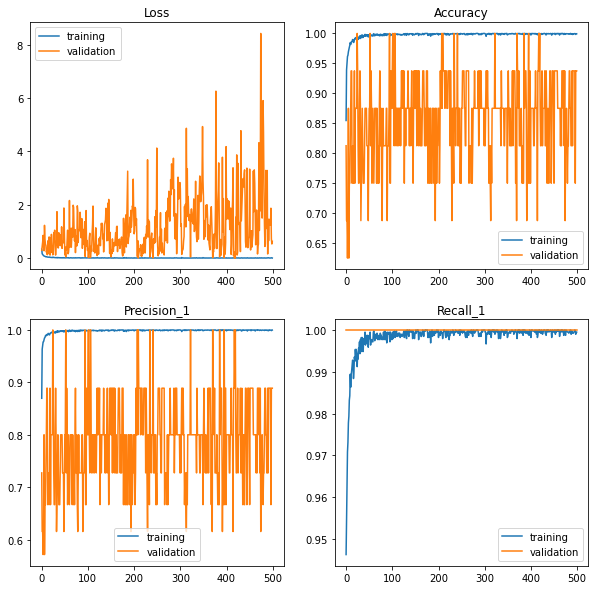

In [27]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Loss')
plt.plot(history.epoch, history.history['loss'], label='training')
plt.plot(history.epoch, history.history['val_loss'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 2)
plt.title('Accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 3)
plt.title('Precision_1')
plt.plot(history.epoch, history.history['precision_1'], label='training')
plt.plot(history.epoch, history.history['val_precision_1'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 4)
plt.title('Recall_1')
plt.plot(history.epoch, history.history['recall_1'], label='training')
plt.plot(history.epoch, history.history['val_recall_1'], label='validation')
plt.legend(loc='best')

plt.show()

In [32]:
model.save("./modeli/stefan/model_1_epoha_500.h5")

In [33]:
import json
  
# Serializing json 
json_history = json.dumps(history.history, indent = 4)
  
# Writing json
with open("./modeli/stefan/model_1_epoha_500.json", "w") as outfile:
    outfile.write(json_history)

In [ ]:
# loadovanje modela
"""from tensorflow.keras.models import load_model

model2 = load_model('trainedmodel_20Epoch.h5')"""

In [34]:
#loadovanje istorije
'''
with open('./modeli/stefan/model_1_epoha_500.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
'''

In [71]:
#history.history.keys()

In [72]:
#len(history.history['loss'])

In [38]:
directory_test = "../chest_xray_norm/test"
x_test, y_test = get_data(directory_test)

In [56]:
y_pred = model.predict(x_test)

In [46]:
#y_pred_round = np.round(y_pred)

In [57]:
y_pred = y_pred.astype(int)

In [68]:
#y_test

In [69]:
#y_pred

In [63]:
y_pred = np.ravel(y_pred)

In [64]:
tacnost = [y_pred==y_test]

In [70]:
#tacnost

In [66]:
tacnost = np.average(tacnost)

In [67]:
tacnost

0.8413461538461539